In [5]:
!pip install tqdm

In [1]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from google.colab import drive
from transformers import BertForSequenceClassification
from peft import LoraConfig, TaskType
from peft import get_peft_model
from tqdm import tqdm


In [2]:
import pandas as pd

In [3]:
#pip install torch torchvision torchaudio

In [4]:
NAICS_2022 = pd.read_csv('NAICS_2022.csv')

In [5]:
NAICS_2022['INDUSTRY_GROUP'] = NAICS_2022['Code']//100

NAICS_2022 = NAICS_2022.dropna(subset=['EXAMPLE']).reset_index(drop=True)

# We define a function called extract_examples whose input is a text and output is a list of words
# which are extracted from that text. After doing some preprocess on the text, we split the text by semi-colon.

def extract_examples(text):
    # Lowercase the text
    text = text.lower()
    text = text.replace('for example, ','')
    
    # Remove punctuation marks
    #text = ''.join(char for char in text if char not in punctuation_without_semicolon)
    
    # Remove stopwords
    words = text.split()
    #words = [word for word in words if word not in stopwords]
    
    for i in range(len(words)):
        if ";" in words[i]:
            word = words[i].replace(";", "")
            stemmed_word = word + ";"
            words[i] = stemmed_word        
        #else:
         #   words[i] = stemmer.stem(words[i])
    
    
    
    # Stem the words
    #words = [stemmer.stem(word) for word in words]
    
    # Join the words back into a string
    text = ' '.join(words)
    
    list_words = text.rstrip('; ').split(';')
    # Use Yake to extract keywords from the preprocessed text
    #keywords = custom_kw_extractor.extract_keywords(text)
    #keywords = [t[0] for t in keywords]
    #if len(keywords) != 1:
       # keywords = [t for t in keywords if len(t.split()) > 1]
        
    #keywords = [t[0] for t in keywords if len(t[0].split()) > 1]
    
    return list_words


# Here we apply the extract_examples function on the EXAMPLE column of the dataset. 
# EXAMPLE column comprises of many examples which are separated by semi-colon.

NAICS_2022['EXAMPLE_SPLIT'] = NAICS_2022['EXAMPLE'].apply(lambda x: extract_examples(x))


# Labeling the INDUSTRY_GROUP column: we have 312 classes in the industry group level (first 4 digits of NAICS code)
# and we label them from 0 to 311.

INPUT_DF = NAICS_2022.copy()


INPUT_DF_EXPLODE = INPUT_DF.explode('EXAMPLE_SPLIT').reset_index(drop = True)




In [6]:
value_counts = INPUT_DF_EXPLODE['Code'].value_counts()
# Get the values that occur more than once
values_to_keep = value_counts[value_counts > 1].index

# Filter the DataFrame to keep only rows where the value in 'a' occurs more than once
INPUT_DF_EXPLODE = INPUT_DF_EXPLODE[INPUT_DF_EXPLODE['Code'].isin(values_to_keep)].reset_index(drop = True)

In [7]:
INPUT_DF_EXPLODE.Code.nunique()

869

In [8]:
mapping_IG = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.INDUSTRY_GROUP.unique()))}
INPUT_DF_EXPLODE['industry_group_label'] = INPUT_DF_EXPLODE['INDUSTRY_GROUP'].map(mapping_IG)

In [9]:
mapping_NAICS = {sec:idx for idx, sec in enumerate(list(INPUT_DF_EXPLODE.Code.unique()))}
INPUT_DF_EXPLODE['naics_label'] = INPUT_DF_EXPLODE['Code'].map(mapping_NAICS)

In [10]:
mapping_IG_reverse = {v:k for k, v in mapping_IG.items()}
mapping_NAICS_reverse = {v:k for k, v in mapping_NAICS.items()}

In [11]:
INPUT_DF_EXPLODE_SELECT = INPUT_DF_EXPLODE[['Class definition','EXAMPLE_SPLIT','industry_group_label','naics_label']]

In [12]:
INPUT_DF_EXPLODE_SELECT

,Class definition,EXAMPLE_SPLIT,industry_group_label,naics_label
0,This Canadian industry comprises establishment...,"soybean farming, field and seed production",0,0
1,This Canadian industry comprises establishment...,"soybeans (soya beans), growing",0,0
2,This Canadian industry comprises establishment...,canola (rapeseed) farming,0,1
3,This Canadian industry comprises establishment...,linseed (flaxseed) growing,0,1
4,This Canadian industry comprises establishment...,mixed oilseeds (except soybean) farming,0,1
...,...,...,...,...
19133,This Canadian industry comprises establishment...,"organization of american states, office in ca...",319,868
19134,This Canadian industry comprises establishment...,organization of oil producing and exporting c...,319,868
19135,This Canadian industry comprises establishment...,"united nations, office in canada",319,868
19136,This Canadian industry comprises establishment...,"world bank, office in canada",319,868


In [13]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. Using CPU.")

GPU is available!


In [14]:
INPUT_DF_EXPLODE_SELECT.naics_label.nunique()

869

In [15]:
#X_train, X_valid, y_train, y_valid = train_test_split(INPUT_DF_EXPLODE_SELECT['EXAMPLE_SPLIT'], 
 #                                                     INPUT_DF_EXPLODE_SELECT['naics_label'], test_size=0.1, random_state=42)

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(
    INPUT_DF_EXPLODE_SELECT['EXAMPLE_SPLIT'],
    INPUT_DF_EXPLODE_SELECT['industry_group_label'],
    test_size=0.1,
    random_state=42,
    stratify=INPUT_DF_EXPLODE_SELECT['industry_group_label']
)

In [17]:
len(list(set(list(y_train))))

320

In [18]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
valid_encodings = tokenizer(list(X_valid), truncation=True, padding=True, return_tensors='pt')

In [19]:
train_encodings

{'input_ids': tensor([[  101, 10013,  2240,  ...,     0,     0,     0],
        [  101,  6617,  1005,  ...,     0,     0,     0],
        [  101,  4517, 20145,  ...,     0,     0,     0],
        ...,
        [  101, 10250, 19915,  ...,     0,     0,     0],
        [  101, 23750, 25496,  ...,     0,     0,     0],
        [  101, 11408,  1006,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [20]:
# Convert labels to tensors
train_labels = torch.tensor(list(y_train))
valid_labels = torch.tensor(list(y_valid))


In [21]:
train_labels

tensor([ 29, 306,  67,  ...,  21,  66,  55])

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_encodings = {key: val.to(device) for key, val in train_encodings.items()}
valid_encodings = {key: val.to(device) for key, val in valid_encodings.items()}
train_labels = train_labels.to(device)
valid_labels = valid_labels.to(device)

In [23]:
train_encodings

{'input_ids': tensor([[  101, 10013,  2240,  ...,     0,     0,     0],
         [  101,  6617,  1005,  ...,     0,     0,     0],
         [  101,  4517, 20145,  ...,     0,     0,     0],
         ...,
         [  101, 10250, 19915,  ...,     0,     0,     0],
         [  101, 23750, 25496,  ...,     0,     0,     0],
         [  101, 11408,  1006,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [24]:
train_labels

tensor([ 29, 306,  67,  ...,  21,  66,  55], device='cuda:0')

In [25]:
from torch.utils.data import TensorDataset, DataLoader

# Assuming train_encoding and train_labels are your input data
train_dataset = TensorDataset(train_encodings['input_ids'], 
                              train_encodings['token_type_ids'], 
                              train_encodings['attention_mask'], 
                              train_labels)


In [26]:
# Set batch size according to your preference
batch_size = 16

# Create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [27]:
valid_dataset = TensorDataset(valid_encodings['input_ids'], 
                              valid_encodings['token_type_ids'], 
                              valid_encodings['attention_mask'], 
                              valid_labels)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [28]:
NUM_CLASS = len(list(set(list(y_train))))

In [29]:
NUM_CLASS

320

In [30]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased', 
    num_labels=NUM_CLASS
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, r=8, lora_alpha=1, lora_dropout=0.1
)

model = get_peft_model(model, lora_config)

# Set up training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.to(device)

# Count trainable parameters
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_trainable_params}")

# Count total parameters (including non-trainable)
num_total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_total_params}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of trainable parameters: 540992
Total number of parameters: 110269312


In [32]:
540992/110269312

0.00490609753691036

In [31]:
print(model)

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): BertForSequenceClassification(
      (bert): BertModel(
        (embeddings): BertEmbeddings(
          (word_embeddings): Embedding(30522, 768, padding_idx=0)
          (position_embeddings): Embedding(512, 768)
          (token_type_embeddings): Embedding(2, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): BertEncoder(
          (layer): ModuleList(
            (0-11): 12 x BertLayer(
              (attention): BertAttention(
                (self): BertSelfAttention(
                  (query): Linear(
                    in_features=768, out_features=768, bias=True
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): ModuleDict(
                      (default): Linear(in_features=768, out_

In [34]:
from transformers import BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, balanced_accuracy_score
from tqdm import tqdm

# Number of training epochs
NUM_EPOCHS = 10
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader)*NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()



# Lists to store training losses and F1 scores
train_losses = []
valid_losses = []
f1_scores = []
balanced_accuracies = []
# Training loop with tqdm
for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0

    # Use tqdm to create a progress bar
    progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', leave=False)

    for batch in progress_bar:
        input_ids, token_type_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping to prevent exploding gradients

        optimizer.step()
        scheduler.step()

        # Update the tqdm progress bar with the current loss
        progress_bar.set_postfix({'Training Loss': loss.item()})

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    # Validation
    model.eval()
    total_valid_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in valid_dataloader:
            input_ids, token_type_ids, attention_mask, labels = batch

            outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            total_valid_loss += loss.item()

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    # Calculate F1 score
    f1 = f1_score(all_labels, all_preds, average='weighted')
    f1_scores.append(f1)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    balanced_accuracies.append(balanced_acc)

    # Print training and validation statistics
    print(f'Epoch {epoch + 1}/{NUM_EPOCHS}:')
    print(f'Training Loss: {average_train_loss}')
    print(f'Validation Loss: {average_valid_loss}')
    print(f'F1 Score: {f1}')
    print(f'Balanced Accuracy: {balanced_acc}')
    print('-' * 50)


Epoch 1/10:
Training Loss: 3.5055981997327885
Validation Loss: 2.1575787484645845
F1 Score: 0.4732585768894675
Balanced Accuracy: 0.3010826775453184
--------------------------------------------------


Epoch 2/10:
Training Loss: 1.6587605665653198
Validation Loss: 1.3646453201770783
F1 Score: 0.6457100727172546
Balanced Accuracy: 0.4666666728757815
--------------------------------------------------


Epoch 3/10:
Training Loss: 0.9509596565639741
Validation Loss: 1.0383311272909244
F1 Score: 0.7367638126334053
Balanced Accuracy: 0.5940342423623972
--------------------------------------------------


Epoch 4/10:
Training Loss: 0.5479970782261926
Validation Loss: 0.9192217960953712
F1 Score: 0.7771228151208922
Balanced Accuracy: 0.6684233161882015
--------------------------------------------------


Epoch 5/10:
Training Loss: 0.32171278023537153
Validation Loss: 0.8359877929712335
F1 Score: 0.7881990858437201
Balanced Accuracy: 0.6943965895042671
--------------------------------------------------


Epoch 6/10:
Training Loss: 0.1819184483197572
Validation Loss: 0.8503637941554189
F1 Score: 0.7991295673659142
Balanced Accuracy: 0.7283042930664383
--------------------------------------------------


Epoch 7/10:
Training Loss: 0.10717761831508539
Validation Loss: 0.8656136797275394
F1 Score: 0.8048320379651425
Balanced Accuracy: 0.7477640494991196
--------------------------------------------------


Epoch 8/10:
Training Loss: 0.06244758986751225
Validation Loss: 0.8573804115333284
F1 Score: 0.8138926443762344
Balanced Accuracy: 0.7592269815224727
--------------------------------------------------


C:\Users\User\Desktop\Lora 2\.venv\Lib\site-packages\sklearn\metrics\_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 9/10:
Training Loss: 0.03977706420759367
Validation Loss: 0.8520736526542654
F1 Score: 0.8189403473926167
Balanced Accuracy: 0.771866271769918
--------------------------------------------------


Epoch 10/10:
Training Loss: 0.0301669634934411
Validation Loss: 0.8580603966101383
F1 Score: 0.818669244204441
Balanced Accuracy: 0.7668365473959313
--------------------------------------------------


In [3]:
with open('train_losses_bert.txt', 'w') as file:
    for item in train_losses:
        file.write(f"{item}\n")

with open('valid_losses_bert.txt', 'w') as file:
    for item in valid_losses:
        file.write(f"{item}\n")

with open('f1_scores_bert.txt', 'w') as file:
    for item in f1_scores:
        file.write(f"{item}\n")

with open('balanced_accuracies_bert.txt', 'w') as file:
    for item in balanced_accuracies:
        file.write(f"{item}\n")

In [5]:
with open('train_losses_bert.txt', 'r') as file:
    train_losses_bert = [float(line.strip()) for line in file]

with open('valid_losses_bert.txt', 'r') as file:
    valid_losses_bert = [float(line.strip()) for line in file]

with open('f1_scores_bert.txt', 'r') as file:
    f1_scores_bert = [float(line.strip()) for line in file]

with open('balanced_accuracies_bert.txt', 'r') as file:
    balanced_accuracies_bert = [float(line.strip()) for line in file]



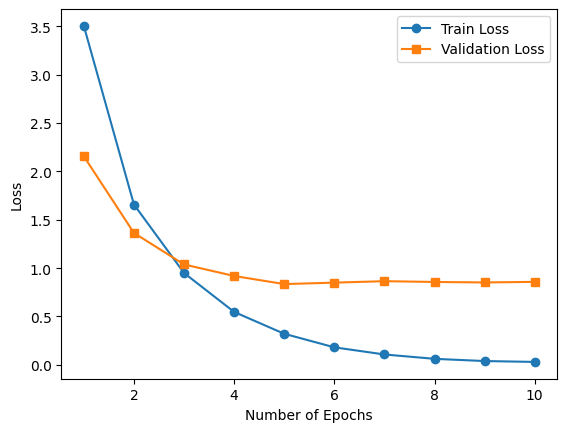

In [6]:
import matplotlib.pyplot as plt

# Sample data
x = [1, 2, 3, 4, 5,6,7,8,9,10]


# Plotting the first list
plt.plot(x, train_losses_bert, label='Train Loss', marker='o')

# Plotting the second list
plt.plot(x, valid_losses_bert, label='Validation Loss', marker='s')

# Adding labels to the plot
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

# Prediction of TM dataset based on NICE classes

In [40]:
Sample_TM_800_Unique_Files = pd.read_excel('Sample_TM_800_Unique_Files.xlsx')

In [41]:
Sample_TM_800_Unique_Files = Sample_TM_800_Unique_Files.dropna(subset=['TEXT']).reset_index(drop=True)

In [42]:
len(Sample_TM_800_Unique_Files)

2083

In [43]:
texts = Sample_TM_800_Unique_Files['TEXT'].tolist()

In [44]:
len(texts)

2083

In [45]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='pt')

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

In [47]:
test_encodings

{'input_ids': tensor([[  101,  3784,  5096,  ...,     0,     0,     0],
         [  101, 19018,  2005,  ...,     0,     0,     0],
         [  101,  4346,  2592,  ...,     0,     0,     0],
         ...,
         [  101, 11128,  2578,  ...,     0,     0,     0],
         [  101,  4511,  1011,  ...,     0,     0,     0],
         [  101,  6475,  1996,  ...,     0,     0,     0]], device='cuda:0'),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]], device='cuda:0'),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')}

In [48]:
test_dataset = TensorDataset(test_encodings['input_ids'], 
                              test_encodings['token_type_ids'], 
                              test_encodings['attention_mask']
                              )

In [49]:
batch_size = 16

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [53]:
model.eval()
test_preds = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, token_type_ids, attention_mask = batch  # adjust based on your input features

        # Make predictions using the model
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Assuming a classification task, get predicted class labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds.extend(preds)

In [54]:
Sample_TM_800_Unique_Files['industry_group_label_pred'] = test_preds

In [55]:
def map_values(value):
    return mapping_IG_reverse.get(value, value)  # Use get to handle cases where the key is not in the dictionary

# Apply the function to create the new column
Sample_TM_800_Unique_Files['industry_group_pred'] = Sample_TM_800_Unique_Files['industry_group_label_pred'].apply(map_values)

In [65]:
Sample_TM_800_Unique_Files[160:170]

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne (multi),NAICS Marianne,NAICS Sebastien,IND,TEXT,industry_group_label_pred,industry_group_pred
160,2134459_0,8,la tablee des chefs,455212,455212.0,332210,0,kitchen knives; kitchen mandolines; scissors f...,87,3322
161,2134459_0,35,la tablee des chefs,NaN,NaN,624210,NaN,"food recovery services, such as, managing logi...",276,6242
162,2134459_0,16,la tablee des chefs,NaN,NaN,513130,NaN,cookbooks; paper bags; plastic shopping bags,64,3222
163,2134459_0,36,la tablee des chefs,NaN,NaN,813210,NaN,charitable fund raising services,303,8132
164,2134459_0,18,la tablee des chefs,NaN,NaN,322220,NaN,grocery tote bags; shopping bags,174,4594
165,2134459_0,39,la tablee des chefs,NaN,NaN,624210,NaN,"food brokerage services, such as, acting as a ...",17,1152
166,2134459_0,21,la tablee des chefs,455212,455212.0,332210,0,cookware; chopping boards for kitchen use; gra...,249,5617
167,2134459_0,41,la tablee des chefs,611690,611690.0,611510,0*,"providing workshops, classes, and camps in the...",259,6116
168,2134459_0,25,la tablee des chefs,458114,458114.0,458119,0**,casual clothing and t-shirts,55,3152
169,2134459_0,43,la tablee des chefs,624210,624210.0,624210,1,providing food to charitable organizations for...,276,6242


In [ ]:
15,19,23,27*,

In [58]:
Sample_TM_800_Unique_Files['TEXT'][15]

'promotion of the planting of trees and contribution to or completion of similar environmental remediation and stewardship projects by individuals and companies; social impact and remediation auditing services, namely auditing the planting of trees and contribution to or completion of similar environmental remediation and social impact projects offered in conjunction with the sales of products and services of others; social impact and remediation tracking and reporting services, namely tracking the status and completion of the planting of trees and contribution to or completion of similar environmental remediation and social impact projects and making the tracking information available through software or web site interfaces;'

In [64]:
IG = 5413
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class definition'].reset_index(drop = True)[i])

This Canadian industry comprises establishments primarily engaged in planning and designing the construction of residential, institutional, leisure, commercial and industrial buildings and other structures by applying knowledge of design, construction procedures, zoning regulations, building codes and building materials.
This Canadian industry comprises establishments primarily engaged in planning, designing and administering the development of land areas for projects such as parks and other recreational areas, airports, highways, hospitals, schools, land subdivisions, and commercial, industrial and residential areas by applying knowledge of land characteristics, location of buildings and structures, use of land areas, and design of landscape projects.
This Canadian industry comprises establishments primarily engaged in applying principles of engineering in the design, development and utilization of machines, materials, instruments, structures, processes and systems.
This Canadian indu

In [63]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['Class title'].reset_index(drop = True)[i])

Architectural services
Landscape architectural services
Engineering services
Drafting services
Building inspection services
Geophysical surveying and mapping services
Surveying and mapping (except geophysical) services
Testing laboratories


In [60]:
for i in range(len(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True))):
    print(NAICS_2022[NAICS_2022.INDUSTRY_GROUP == IG]['EXAMPLE_SPLIT'].reset_index(drop = True)[i])


['architects (except landscape), offices of', ' architectural consultants (except landscape)', ' architectural design services and advice', ' buildings and structures, architectural design services (except landscape)']
['city, town or urban planning services (except engineers)', ' garden planning services', ' industrial development planning service (i.e., urban planning)', ' land use planning services', ' landscape planning services', ' offices of landscape architects', ' recreational area planning and designing services (e.g., ski, golf course, waterparks)', ' waterpark designing and planning']
['acoustical engineering consulting and design services', ' aeronautical design services', ' boat engineering designing services', ' chemical engineering services', ' civil engineering services', ' combustion and heating engineering consultants', ' construction engineering services', ' consulting engineering services', ' electrical and electronic engineering services', ' electrical engineering 

In [66]:
Sample_TM_800_Unique_Files.to_csv('Sample_TM_800_Unique_Files_BERT_PREDICT.csv', index=False)

# Predicting top three classes

In [119]:
model.eval()
test_preds_top3 = []

# Specify the number of top classes you want (e.g., 3)
top_k = 3

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, token_type_ids, attention_mask = batch  # adjust based on your input features

        # Make predictions using the model
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Assuming a classification task, get top k predicted class labels
        _, topk_preds = torch.topk(logits, k=top_k, dim=1)
        topk_preds = topk_preds.cpu().numpy()
        test_preds_top3.extend(topk_preds)

In [120]:
Sample_TM_800_Unique_Files['industry_group_label_pred_top3'] = test_preds_top3

In [122]:
def list_labeld_to_IG(labels):
    return [mapping_IG_reverse[s] for s in labels]

Sample_TM_800_Unique_Files['industry_group_pred_top3'] = Sample_TM_800_Unique_Files['industry_group_label_pred_top3'].apply(lambda x: list_labeld_to_IG(x))

In [189]:
Sample_TM_800_Unique_Files[170:180]

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne (multi),NAICS Marianne,NAICS Sebastien,IND,TEXT,industry_group_label_pred,industry_group_pred,industry_group_label_pred_top3,industry_group_pred_top3
170,2134459_0,29,la tablee des chefs,NaN,NaN,311990,NaN,"prepared meals; preserved foods, including pre...",40,3114,"[40, 43, 44]","[3114, 3117, 3118]"
171,2134658_0,9,legacy enterprises ltd,459210,459210.0,516219,0,"electronic books; virtual goods, namely, downl...",214,5192,"[214, 205, 213]","[5192, 5122, 5182]"
172,2134658_0,41,legacy enterprises ltd,513130,513130.0,516219,0*,"publication of electronic books, journals, art...",214,5192,"[214, 206, 301]","[5192, 5131, 8129]"
173,2134658_0,16,legacy enterprises ltd,513130,513130.0,459210,0,"printed publications, namely, books, magazines...",206,5131,"[206, 65, 240]","[5131, 3231, 5418]"
174,2134658_0,25,legacy enterprises ltd,458114,458114.0,458119,0**,"clothing, namely t-shirts, sweatshirts, sweat ...",55,3152,"[55, 56, 51]","[3152, 3159, 3133]"
175,2152413_0,36,magenta capital corporation,522310,522310.0,522310,1,"Financial services, namely mortgage brokering ...",217,5223,"[217, 216, 233]","[5223, 5222, 5411]"
176,2134524_0,12,mitsubishi motor sales of canada inc,441330,441330.0,336110,0,Automobiles; automobile parts; braking systems...,114,3363,"[114, 294, 296]","[3363, 8111, 8113]"
177,2134524_0,35,mitsubishi motor sales of canada inc,441110,441110.0,441110,1,Automobile dealership services.,155,4413,"[155, 166, 154]","[4413, 4571, 4412]"
178,2134524_0,36,mitsubishi motor sales of canada inc,NaN,NaN,441110,NaN,Motor vehicle services including warranty serv...,294,8111,"[294, 197, 155]","[8111, 4884, 4413]"
179,2134524_0,45,mitsubishi motor sales of canada inc,NaN,NaN,441110,NaN,Providing information about automobiles via a ...,214,5192,"[214, 213, 209]","[5192, 5182, 5162]"


In [209]:
Sample_TM_800_Unique_Files['TEXT'][176]

'Motor vehicle services including warranty services, financing and leasing services and repair services.'

In [210]:
NAICS_2022[NAICS_2022.INDUSTRY_GROUP == 8111]['Class definition'].reset_index(drop = True)[0]

'This Canadian industry comprises establishments primarily engaged in providing a range of mechanical and electrical repair and maintenance services for motor vehicles, such as engine repair and maintenance, exhaust system replacement, transmission repair and electrical system repair.'

In [217]:
NAICS_2022[NAICS_2022.INDUSTRY_GROUP == 3256].reset_index(drop=True)['Class definition'][0]

'This Canadian industry comprises establishments primarily engaged in manufacturing soap and other cleaning compounds.'

# Prediction of TM datset based on Goods and Services classes

In [84]:
Sample_TM_800_Unique_Files_goods_and_services_classes = pd.read_excel('Sample_TM_800_Unique_Files_goods_and_services_classes.xlsx')

In [86]:
len(Sample_TM_800_Unique_Files_goods_and_services_classes)

22150

In [92]:
Sample_TM_800_Unique_Files_goods_and_services_classes = Sample_TM_800_Unique_Files_goods_and_services_classes.dropna(subset=['TEXT_SPLIT']).reset_index(drop=True)

In [93]:
len(Sample_TM_800_Unique_Files_goods_and_services_classes)

22142

In [94]:
texts_GS = Sample_TM_800_Unique_Files_goods_and_services_classes['TEXT_SPLIT'].tolist()
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(texts_GS, truncation=True, padding=True, return_tensors='pt')

In [95]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
test_encodings = {key: val.to(device) for key, val in test_encodings.items()}

In [97]:
test_dataset = TensorDataset(test_encodings['input_ids'], 
                              test_encodings['token_type_ids'], 
                              test_encodings['attention_mask']
                              )

batch_size = 16

# Create DataLoader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [99]:
model.eval()
test_preds_GS = []

# Iterate through the test DataLoader
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, token_type_ids, attention_mask = batch  # adjust based on your input features

        # Make predictions using the model
        outputs = model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Assuming a classification task, get predicted class labels
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        test_preds_GS.extend(preds)

In [100]:
Sample_TM_800_Unique_Files_goods_and_services_classes['industry_group_label_pred'] = test_preds_GS

In [101]:
Sample_TM_800_Unique_Files_goods_and_services_classes['industry_group_pred'] = Sample_TM_800_Unique_Files_goods_and_services_classes['industry_group_label_pred'].apply(map_values)

In [103]:
Sample_TM_800_Unique_Files_goods_and_services_classes[10:20]

,UNIQUE_FILE_NUMBER,NICE_CLASS_CODE,LEGAL_NAME_UPD,NAICS Marianne (multi),NAICS Marianne,NAICS Sebastien,IND,TEXT_SPLIT,industry_group_label_pred,industry_group_pred
10,2153878_0,41,911979 alberta ltd,611710*\n611690,611710.0,621390,0.0,providing information to others in the field ...,264,6214
11,2153878_0,44,911979 alberta ltd,456110,456110.0,456110,1.0,prescription refill services,301,8129
12,2153878_0,44,911979 alberta ltd,456110,456110.0,456110,1.0,online prescription refill services,267,6219
13,2153878_0,44,911979 alberta ltd,812190,812190.0,621390,0.0,consulting services in the field of cannabis ...,238,5416
14,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,"skin care preparations, namely, soaps, body wa...",72,3256
15,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,face wash,298,8121
16,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,body scrub,298,8121
17,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,cosmetic facial toner,72,3256
18,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,hand lotion,298,8121
19,2166784_0,3,911979 alberta ltd,456110,456110.0,456110,1.0,face cleaning wipes,300,8123


In [108]:
NAICS_2022[NAICS_2022.INDUSTRY_GROUP == 8129]

,Level,Hierarchical structure,Code,Parent,Class title,Superscript,Class definition,EXAMPLE,INDUSTRY_GROUP,EXAMPLE_SPLIT
877,5,Canadian industry,812910,81291,Pet care (except veterinary) services,US,This Canadian industry comprises establishment...,"animal shelters; boarding kennel service, pet...",8129,"[animal shelters, boarding kennel service, pe..."
878,5,Canadian industry,812921,81292,Photo finishing laboratories (except one-hour),US,This Canadian industry comprises establishment...,developing and printing of films (except for ...,8129,[developing and printing of films (except for ...
879,5,Canadian industry,812922,81292,One-hour photo finishing,US,This Canadian industry comprises establishment...,digital photo printing (including self-serve)...,8129,[digital photo printing (including self-serve)...
880,5,Canadian industry,812930,81293,Parking lots and garages,US,This Canadian industry comprises establishment...,valet parking services;,8129,[valet parking services]
881,5,Canadian industry,812990,81299,All other personal services,US,This Canadian industry comprises establishment...,"bail bonding services; balloon-o-gram, servic...",8129,"[bail bonding services, balloon-o-gram, servi..."
